In [8]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from pyproj import Transformer, Geod
import geojson
import re
import matplotlib.pyplot as plt
from pathlib import Path

class WildfireAnalyzer:
    def __init__(self, city_name, city_coords, start_year=1961, end_year=2021, debug=False):
        """
        Initialize the analyzer with city information and analysis period.
        
        Args:
            city_name (str): Name of the city
            city_coords (tuple): (latitude, longitude) of the city
            start_year (int): Start year for analysis period
            end_year (int): End year for analysis period
            debug (bool): Enable detailed error logging
        """
        self.city_name = city_name
        self.city_coords = city_coords
        self.start_year = start_year
        self.end_year = end_year
        self.max_distance = 650  # miles
        self.season_start_month = 5  # May
        self.season_end_month = 10   # October
        self.debug = debug
        
        # Initialize geodetic calculator using WGS84 ellipsoid
        self.geodcalc = Geod(ellps='WGS84')
        
        # Initialize coordinate transformer
        self.to_epsg4326 = Transformer.from_crs("ESRI:102008", "EPSG:4326")
        
        # Initialize counters for debugging
        self.processed_count = 0
        self.error_count = 0
        self.skipped_count = 0
        
        # Compile regex pattern for date extraction
        self.discovery_date_pattern = r"Listed Wildfire Discovery Date\(s\): ([^|]+)"

    def log_debug(self, message):
        """Log debug messages if debug mode is enabled."""
        if self.debug:
            print(f"DEBUG: {message}")

    def extract_discovery_date(self, date_string):
        """
        Extract the earliest discovery date from the complex date string.
        
        Args:
            date_string (str): Complex date string from Listed_Fire_Dates
            
        Returns:
            str: Earliest discovery date in MM/DD/YYYY format, or None if not found
        """
        try:
            if not date_string:
                return None
                
            # Find discovery dates section
            match = re.search(self.discovery_date_pattern, date_string)
            if not match:
                return None
                
            # Extract all dates from the discovery dates section
            discovery_dates_str = match.group(1)
            date_matches = re.findall(r'(\d{4}-\d{2}-\d{2})', discovery_dates_str)
            
            if not date_matches:
                return None
                
            # Convert to datetime objects and find earliest
            dates = [datetime.strptime(d, '%Y-%m-%d') for d in date_matches]
            earliest_date = min(dates)
            
            # Convert to MM/DD/YYYY format
            return earliest_date.strftime('%m/%d/%Y')
            
        except Exception as e:
            self.log_debug(f"Date extraction error: {str(e)}")
            return None

    def validate_feature(self, feature):
        """
        Validate feature data structure and required fields.
        
        Args:
            feature (dict): Fire feature from GeoJSON data
            
        Returns:
            bool: True if feature is valid
        """
        try:
            # Check basic structure
            if not isinstance(feature, dict):
                self.log_debug("Feature is not a dictionary")
                return False
                
            # Check required components
            if 'attributes' not in feature:
                self.log_debug("No attributes in feature")
                return False
                
            if 'geometry' not in feature:
                self.log_debug("No geometry in feature")
                return False
                
            # Check required attributes
            required_attrs = ['Fire_Year', 'GIS_Acres', 'Listed_Fire_Names', 
                            'Assigned_Fire_Type', 'Listed_Fire_Dates']
            for attr in required_attrs:
                if attr not in feature['attributes']:
                    self.log_debug(f"Missing required attribute: {attr}")
                    return False
                    
            # Validate geometry
            if 'rings' not in feature['geometry'] and 'curveRings' not in feature['geometry']:
                self.log_debug("No rings or curveRings in geometry")
                return False
                
            return True
            
        except Exception as e:
            self.log_debug(f"Validation error: {str(e)}")
            return False

    def convert_coords_to_epsg4326(self, coords):
        """
        Convert coordinates from ESRI:102008 to EPSG:4326.
        
        Args:
            coords (list): List of coordinate pairs in ESRI:102008
        
        Returns:
            list: List of converted coordinate pairs in EPSG:4326
        """
        converted_coords = []
        try:
            for coord in coords:
                if len(coord) >= 2:  # Ensure coord has at least 2 elements
                    lat, lon = self.to_epsg4326.transform(coord[0], coord[1])
                    converted_coords.append((lat, lon))
        except Exception as e:
            self.log_debug(f"Coordinate conversion error: {str(e)}")
        return converted_coords

    def calculate_distance(self, fire_coords):
        """
        Calculate minimum distance from fire perimeter to city.
        
        Args:
            fire_coords (list): List of coordinate pairs defining fire perimeter
            
        Returns:
            float: Distance in miles or None if calculation fails
        """
        try:
            if not fire_coords:
                return None
                
            distances = []
            city_lon, city_lat = self.city_coords[1], self.city_coords[0]
            
            for coord in fire_coords:
                d = self.geodcalc.inv(city_lon, city_lat, coord[1], coord[0])
                distance_miles = d[2] * 0.00062137  # Convert meters to miles
                distances.append(distance_miles)
                
            return min(distances) if distances else None
            
        except Exception as e:
            self.log_debug(f"Distance calculation error: {str(e)}")
            return None

    def estimate_smoke_impact(self, fire_size, distance):
        """
        Calculate smoke impact score based on fire size and distance.
        Modified to better correlate with observed PM2.5 levels.
        
        Key changes:
        1. Reduced distance penalty (changed from inverse square to inverse)
        2. Increased weight of fire size
        3. Added baseline minimum impact for nearby fires
        4. Added distance cutoff thresholds
        
        Args:
            fire_size (float): Size of fire in acres
            distance (float): Distance to city in miles
            
        Returns:
            float: Smoke impact score
        """
        try:
            if distance is None or distance <= 0 or fire_size <= 0:
                return 0
                
            # Constants for impact calculation
            SIZE_SCALE = 1e5  # Scaling factor for fire size
            DISTANCE_THRESHOLD = 250  # Miles threshold for full impact
            MAX_DISTANCE = 650  # Maximum distance to consider
            
            # Scale fire size (using cube root to moderate extreme values)
            normalized_size = (fire_size / SIZE_SCALE) ** (1/3)
            
            # Calculate distance factor with thresholds
            if distance <= DISTANCE_THRESHOLD:
                distance_factor = 1.0
            else:
                # Linear decrease in impact beyond threshold
                distance_factor = max(0, 1 - (distance - DISTANCE_THRESHOLD) / (MAX_DISTANCE - DISTANCE_THRESHOLD))
            
            # Calculate base impact
            impact = normalized_size * distance_factor
            
            # Add minimum impact for very large fires regardless of distance
            if fire_size > 100000:  # Threshold for major fires
                impact += 0.05
                
            return impact
            
        except Exception as e:
            self.log_debug(f"Smoke impact calculation error: {str(e)}")
            return 0

    def is_in_fire_season(self, date_str):
        """
        Check if a date falls within the fire season (May 1 - Oct 31).
        
        Args:
            date_str (str): Date string in MM/DD/YYYY format
            
        Returns:
            bool: True if date is in fire season
        """
        if not date_str:
            return True  # If no date provided, include the fire
            
        try:
            date = datetime.strptime(date_str, '%m/%d/%Y')
            return self.season_start_month <= date.month <= self.season_end_month
        except:
            self.log_debug(f"Date parsing error for: {date_str}")
            return True  # If date parsing fails, include the fire

    def analyze_fire(self, feature):
        """
        Analyze a single fire feature to determine if it meets criteria and calculate impact.
        
        Args:
            feature (dict): Fire feature from GeoJSON data
            
        Returns:
            dict: Analysis results or None if fire doesn't meet criteria
        """
        self.processed_count += 1
        
        try:
            # Validate feature structure
            if not self.validate_feature(feature):
                self.skipped_count += 1
                return None
                
            attributes = feature['attributes']
            
            # Check if it's a wildfire
            if attributes['Assigned_Fire_Type'] != 'Wildfire':
                self.skipped_count += 1
                self.log_debug("Skipped non-wildfire")
                return None
            
            # Check year criteria
            year = attributes['Fire_Year']
            if not (self.start_year <= year <= self.end_year):
                self.skipped_count += 1
                return None
                
            # Extract and check discovery date
            discovery_date = self.extract_discovery_date(attributes['Listed_Fire_Dates'])
            if discovery_date and not self.is_in_fire_season(discovery_date):
                self.skipped_count += 1
                self.log_debug(f"Skipped fire outside season: {discovery_date}")
                return None
            
            # Get fire perimeter coordinates
            ring_data = None
            if 'rings' in feature['geometry']:
                ring_data = feature['geometry']['rings'][0]
            elif 'curveRings' in feature['geometry']:
                ring_data = feature['geometry']['curveRings'][0]
            
            if not ring_data:
                self.skipped_count += 1
                return None
                
            # Convert coordinates and calculate distance
            converted_coords = self.convert_coords_to_epsg4326(ring_data)
            if not converted_coords:
                self.skipped_count += 1
                return None
                
            distance = self.calculate_distance(converted_coords)
            if distance is None or distance > self.max_distance:
                self.skipped_count += 1
                return None
                
            # Calculate smoke impact
            fire_size = attributes['GIS_Acres']
            smoke_impact = self.estimate_smoke_impact(fire_size, distance)
            
            # Get primary fire name
            fire_names = attributes['Listed_Fire_Names'].split(',')[0].strip()
            if '(' in fire_names:  # Remove count in parentheses if present
                fire_names = fire_names.split('(')[0].strip()
            
            return {
                'year': year,
                'name': fire_names,
                'size_acres': fire_size,
                'distance_miles': distance,
                'smoke_impact': smoke_impact,
                'discovery_date': discovery_date
            }
            
        except Exception as e:
            self.error_count += 1
            self.log_debug(f"Error processing fire: {str(e)}")
            return None

    def analyze_fires(self, features):
        """
        Analyze all fires and compute annual smoke impact.
        
        Args:
            features (list): List of fire features from GeoJSON data
            
        Returns:
            pd.DataFrame: Annual summary of fire impacts
        """
        results = []
        
        # Reset counters
        self.processed_count = 0
        self.error_count = 0
        self.skipped_count = 0
        
        for feature in features:
            result = self.analyze_fire(feature)
            if result:
                results.append(result)
        
        # Print summary statistics
        print(f"\nProcessing Summary:")
        print(f"Total fires processed: {self.processed_count}")
        print(f"Fires included in analysis: {len(results)}")
        print(f"Fires skipped (out of criteria): {self.skipped_count}")
        print(f"Errors encountered: {self.error_count}\n")
        
        # Convert to DataFrame
        if not results:
            print("No fires met the analysis criteria!")
            return pd.DataFrame()
            
        df = pd.DataFrame(results)
        
        # Calculate annual summaries
        annual_summary = df.groupby('year').agg({
            'size_acres': ['count', 'sum'],
            'smoke_impact': 'sum',
            'distance_miles': 'mean'
        }).round(2)
        
        # Flatten column names
        annual_summary.columns = [
            'fires_count', 'total_acres', 'smoke_impact_score', 'avg_distance'
        ]
        
        return annual_summary.sort_index()

    def plot_results(self, annual_summary, output_dir=None):
        """
        Create visualization plots of the analysis results.
        
        Args:
            annual_summary (pd.DataFrame): Analysis results
            output_dir (str): Directory to save plots (optional)
        """
        try:
            # Create figure with subplots
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle(f'Wildfire Analysis Results for {self.city_name} ({self.start_year}-{self.end_year})')

            # Plot 1: Number of Fires per Year
            annual_summary['fires_count'].plot(ax=ax1, kind='bar')
            ax1.set_title('Number of Fires per Year')
            ax1.set_xlabel('Year')
            ax1.set_ylabel('Number of Fires')
            ax1.tick_params(axis='x', rotation=45)

            # Plot 2: Total Acres Burned per Year
            annual_summary['total_acres'].plot(ax=ax2, kind='bar')
            ax2.set_title('Total Acres Burned per Year')
            ax2.set_xlabel('Year')
            ax2.set_ylabel('Acres')
            ax2.tick_params(axis='x', rotation=45)

            # Plot 3: Smoke Impact Score per Year
            annual_summary['smoke_impact_score'].plot(ax=ax3, kind='bar')
            ax3.set_title('Smoke Impact Score per Year')
            ax3.set_xlabel('Year')
            ax3.set_ylabel('Impact Score')
            ax3.tick_params(axis='x', rotation=45)

            # Plot 4: Average Fire Distance per Year
            annual_summary['avg_distance'].plot(ax=ax4, kind='bar')
            ax4.set_title('Average Fire Distance per Year')
            ax4.set_xlabel('Year')
            ax4.set_ylabel('Miles')
            ax4.tick_params(axis='x', rotation=45)

            plt.tight_layout()

            # Save plots if output directory is provided
            if output_dir:
                output_path = Path(output_dir) / f'wildfire_analysis_{self.city_name.lower()}.png'
                plt.savefig(output_path)
                print(f"Plots saved to {output_path}")

            plt.show()

        except Exception as e:
            print(f"Error creating plots: {str(e)}")

In [ ]:
# Example usage for Glendale
city_info = {
    'name': 'Glendale',
    'coords': (33.53, -112.19)  # (lat, lon)
}

# Initialize analyzer with debug mode
analyzer = WildfireAnalyzer(
    city_name=city_info['name'],
    city_coords=city_info['coords'],
    debug=True  # Enable detailed error logging
)

# Create output directory for results
output_dir = 'Part_1/Step_0_and_Step_1/wildfire_analysis_results'
os.makedirs(output_dir, exist_ok=True)

# Read GeoJSON data
SAMPLE_DATA_FILENAME = 'Part_1/data/USGS_Wildland_Fire_Combined_Dataset.json'

Loading data from GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json...
Analyzing fires...
DEBUG: Skipped fire outside season: 11/06/1961
DEBUG: Skipped fire outside season: 12/31/1961
DEBUG: Skipped fire outside season: 11/13/1961
DEBUG: Skipped fire outside season: 12/31/1961
DEBUG: Skipped fire outside season: 01/19/1961
DEBUG: Skipped fire outside season: 12/31/1961
DEBUG: Skipped fire outside season: 12/31/1961
DEBUG: Skipped fire outside season: 01/15/1961
DEBUG: Skipped fire outside season: 11/13/1961
DEBUG: Skipped fire outside season: 12/31/1961
DEBUG: Skipped fire outside season: 12/31/1961
DEBUG: Skipped fire outside season: 04/22/1961
DEBUG: Skipped fire outside season: 12/31/1961
DEBUG: Skipped fire outside season: 01/01/1961
DEBUG: Skipped fire outside season: 02/24/1961
DEBUG: Skipped fire outside season: 12/31/1961
DEBUG: Skipped fire outside season: 12/31/1961
DEBUG: Skipped fire outside season: 12/31/1961
DEBUG: Skipped fire outside season: 11/04/1961
DEBUG: Ski

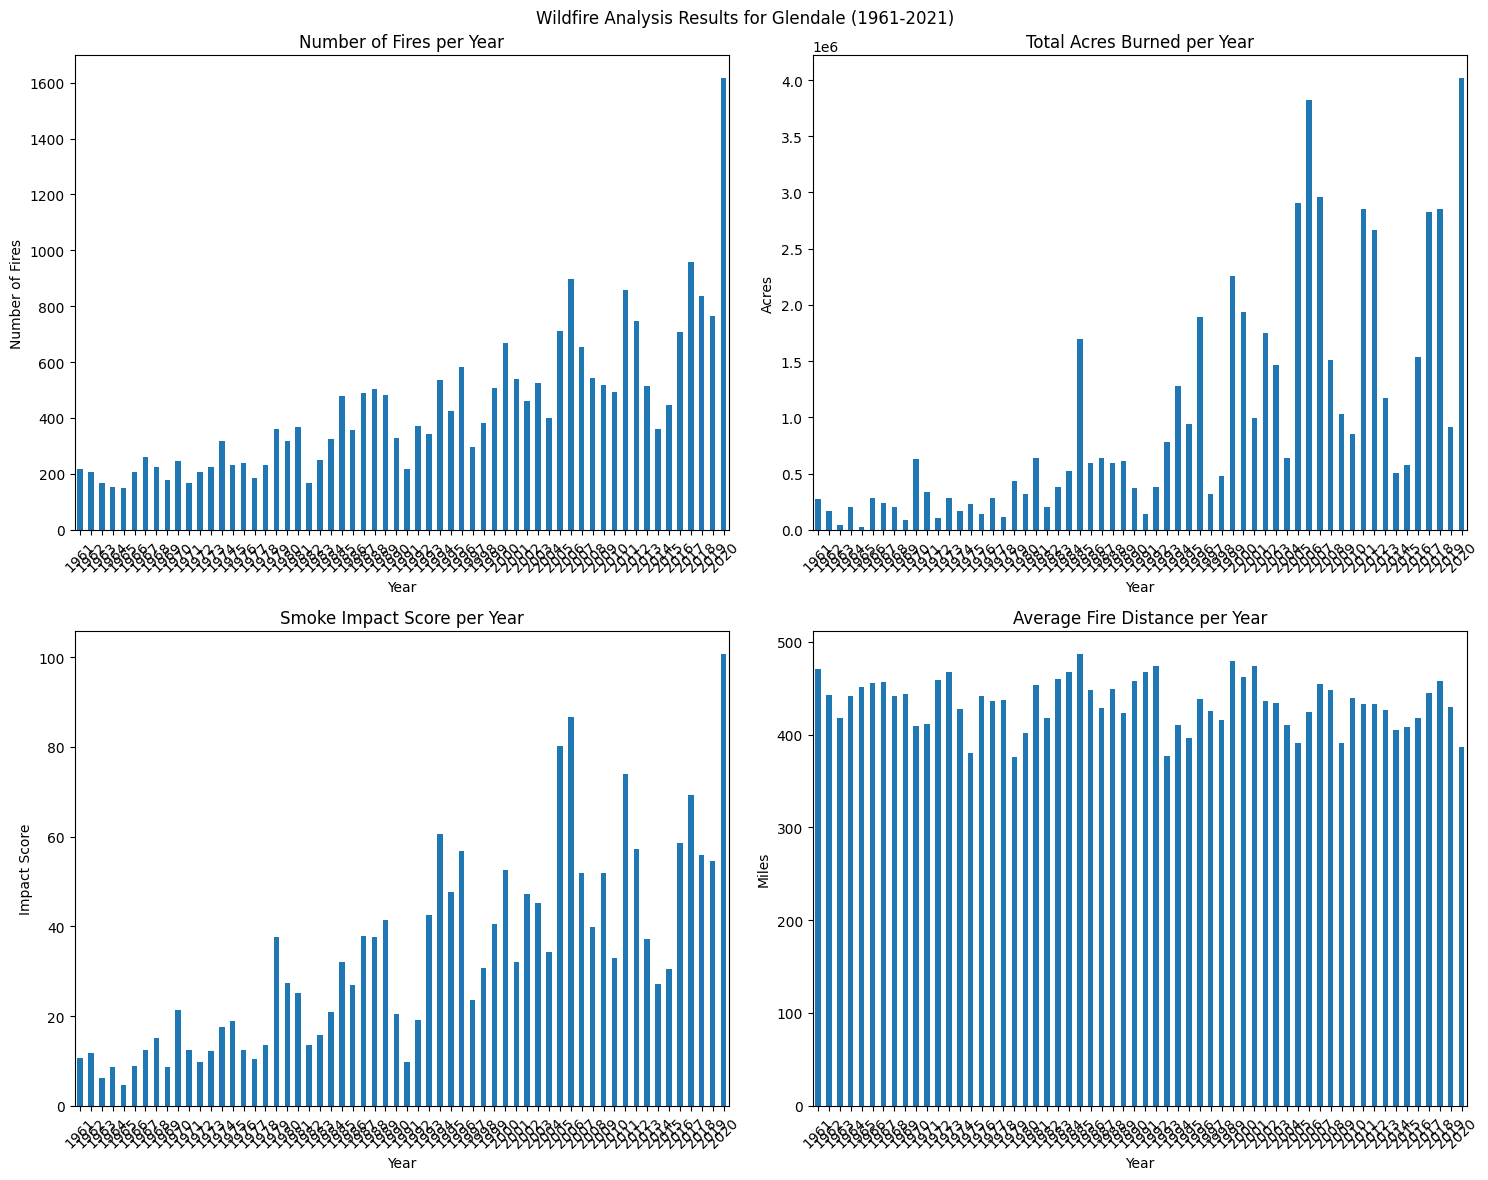

In [10]:
try:
    print(f"Loading data from {SAMPLE_DATA_FILENAME}...")
    with open(SAMPLE_DATA_FILENAME, 'r') as f:
        data = geojson.load(f)
    
    print("Analyzing fires...")
    # Analyze fires
    annual_impact = analyzer.analyze_fires(data['features'])
    
    if not annual_impact.empty:
        # Display results
        print(f"\nWildfire Smoke Impact Analysis for {city_info['name']}")
        print(f"Analysis Period: {analyzer.start_year}-{analyzer.end_year}")
        print(f"Maximum Distance: {analyzer.max_distance} miles")
        print(f"Fire Season: May 1 - October 31\n")
        print(annual_impact)
        
        # Save results to CSV
        csv_output = os.path.join(output_dir, 
            f'wildfire_impact_{city_info["name"].lower()}_{analyzer.start_year}_{analyzer.end_year}.csv')
        annual_impact.to_csv(csv_output)
        print(f"\nResults saved to {csv_output}")
        
        # Create and save plots
        print("\nGenerating visualization plots...")
        analyzer.plot_results(annual_impact, output_dir)
        
    else:
        print("No results to display. Please check the data and filtering criteria.")
        
except FileNotFoundError:
    print(f"Error: Could not find the data file: {SAMPLE_DATA_FILENAME}")
    print("Please ensure the file exists in the specified location.")
except Exception as e:
    print(f"Critical Error: {str(e)}")